데이터 다운로드

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-09-17 18:28:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:f340:10:1802::201b, 2404:f340:10:1803::201b, 2404:f340:10:1800::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:f340:10:1802::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.8MB/s    in 3.4s    

2024-09-17 18:28:18 (19.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip -qq cats_and_dogs_filtered.zip

In [3]:
ls

cats_and_dogs_filtered/     ch03_ex1_data_augmentation.ipynb
cats_and_dogs_filtered.zip  ch03_ex2_classification3.ipynb


In [4]:
# 패키지 임포트
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

In [5]:
#pytorch 버전 확인
import torch
print(torch.__version__)

2.1.0+cu121


In [6]:
# GPU 사용 체크
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

파이토치 데이터셋 클래스

In [14]:
# 데이터세트 정의 클래스
class PyTorchCustomDataset(Dataset):
    def __init__(self
                 , root_dir = "./cats_and_dogs_filtered/train"
                 , transform = None):
        self.image_abs_path = root_dir
        self.transform = transform
        self.label_list = os.listdir(self.image_abs_path)
        self.label_list.sort()
        self.x_list = []
        self.y_list = []
        for label_index, label_str in enumerate(self.label_list):
            img_path = os.path.join(self.image_abs_path, label_str)
            img_list = os.listdir(img_path)
            for img in img_list:
                self.x_list.append(os.path.join(img_path, img))
                self.y_list.append(label_index)
        pass

    def __len__(self):
        return len(self.x_list)

    def __getitem__(self, idx):
        image = Image.open(self.x_list[idx])
        if image.mode is not "RGB":
            image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.y_list[idx]

    def __save_label_map__(self, dst_text_path = "label_map.txt"):
        label_list = self.label_list
        f = open(dst_text_path, 'w')
        for i in range(len(label_list)):
            f.write(label_list[i]+'\n')
        f.close()
        pass

    def __num_classes__(self):
        return len(self.label_list)

<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_162375/3347546921.py:25: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if image.mode is not "RGB":


Model

In [15]:
# 네트워크 정의
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class MODEL(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Dropout()
            , nn.Linear(1000, num_classes)
            , nn.Sigmoid()
        )
    def forward(self, x):
        x = self.network(x)
        return self.classifier(x)

main 함수

In [17]:
# 훈련 메인 함수 정의
import torch
import torch.optim as optim

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

def trainmain():
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    img_width, img_height = 224, 224
    EPOCHS     = 12
    BATCH_SIZE = 32

    #데이터세트 로딩
    transform_train = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.RandomRotation(degrees=15)
                , transforms.ToTensor()
                ])
    transform_test = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                ])
    TrainDataset = PyTorchCustomDataset
    TestDataset = PyTorchCustomDataset
    train_data = TrainDataset(root_dir = "./cats_and_dogs_filtered/train"
                    , transform = transform_train)
    test_data = TestDataset(root_dir = "./cats_and_dogs_filtered/validation"
                    , transform = transform_test)
    train_loader = torch.utils.data.DataLoader(
        train_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    train_data.__save_label_map__()
    num_classes = train_data.__num_classes__()

    #모델 객체 생성, PyTorch_Classification_Model.pt 모델 파일명 지정
    model = MODEL(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt"

    #최적화 함수와 학습률 지정
    #optimizer = optim.Adam(model.parameters(), lr=0.0001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    acc = 0.0

    # 에포크 만큼 훈련, 검증
    for epoch in range(1, EPOCHS + 1):
        model.train()
        tr_loss = 0.0
        tr_correct = 0.0
        for data, target in (train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            tr_loss += F.nll_loss(output,target,reduction='sum').item()
            pred = output.data.max(dim=1,keepdim=True)[1]
            tr_correct += pred.eq(target.view_as(pred)).sum().item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        tr_ep_loss = tr_loss/len(train_loader.dataset)
        tr_ep_accuracy = 100. * tr_correct/len(train_loader.dataset)

        model.eval()
        te_loss = 0
        te_correct = 0
        with torch.no_grad():
            for data, target in (test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                loss = F.cross_entropy(output, target)
                te_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.max(1, keepdim=True)[1]
                te_correct += pred.eq(target.view_as(pred)).sum().item()
        te_ep_loss = te_loss / len(test_loader.dataset)
        te_ep_accuracy = 100. * te_correct / len(test_loader.dataset)
        print('[{}] Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
                epoch, tr_ep_loss, tr_ep_accuracy, te_ep_loss, te_ep_accuracy))

        if acc < te_ep_accuracy:
            acc = te_ep_accuracy
            torch.save(model.state_dict(), model_str)
            print("model saved!")

        train_losses.append(tr_ep_loss)
        train_accuracy.append(tr_ep_accuracy)
        val_losses.append(te_ep_loss)
        val_accuracy.append(te_ep_accuracy)


In [18]:
# 훈련 메인 함수 호출
trainmain()

/home/donggeonyoon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/donggeonyoon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

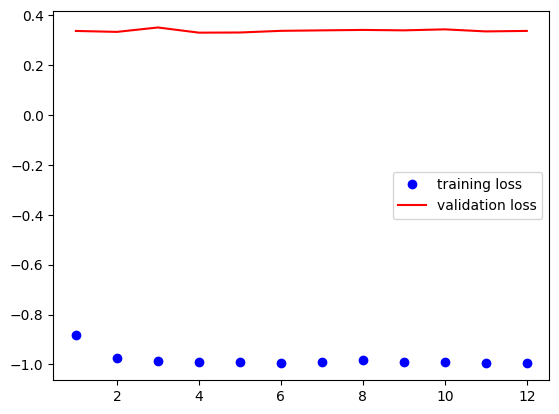

In [ ]:
# 훈련 데이터와 검증 데이터의 손실 그래프
import matplotlib.pyplot as plt

plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

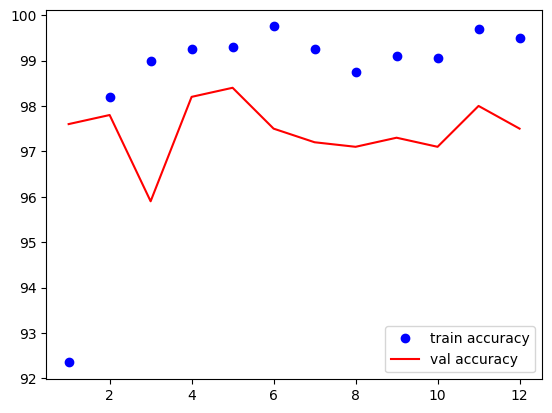

In [ ]:
# 훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

In [ ]:
# PyTorch_Classification_Model.pt 모델 파일 확인
!ls

cats_and_dogs_filtered	    label_map.txt		     sample_data
cats_and_dogs_filtered.zip  PyTorch_Classification_Model.pt


이미지 분류 모델 추론 테스트

In [ ]:
# 테스트 이미지 로딩
import os
PATH = "/content/cats_and_dogs_filtered/validation"
validation_cats_dir = PATH + '/cats'  # directory with our validation cat pictures
validation_dogs_dir = PATH + '/dogs'  # directory with our validation dog pictures
list_of_test_cats_images = os.listdir(validation_cats_dir)
list_of_test_dogs_images = os.listdir(validation_dogs_dir)
for idx in range(len(list_of_test_cats_images)):
    list_of_test_cats_images[idx] = validation_cats_dir + '/'+list_of_test_cats_images[idx]
for idx in range(len(list_of_test_dogs_images)):
    list_of_test_dogs_images[idx] = validation_dogs_dir + '/'+list_of_test_dogs_images[idx]
list_of_test_images = list_of_test_cats_images + list_of_test_dogs_images

In [ ]:
# 로딩된 이미지 경로 프린트
print(list_of_test_cats_images[10])
print(list_of_test_images[501])

/content/cats_and_dogs_filtered/validation/cats/cat.2084.jpg
/content/cats_and_dogs_filtered/validation/dogs/dog.2138.jpg


In [ ]:
# 이미지 보여주는 함수, 이미지 추론 함수

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

#라벨맵 로딩 함수
def load_label_map(textFile):
    return np.loadtxt(textFile, str, delimiter='\t')

#이미지 읽는 함수
def cv_image_read(image_path):
    print(image_path)
    return cv2.imread(image_path)

#이미지 보여주는 함수
def show_image(cv_image):
    rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(rgb)
    plt.show()

#이미지를 분류 모델로 추론한 결과를 텍스트로 보여주는 함수
def print_result(inference_result, class_map):
    class_text = class_map[np.argmax(inference_result)]
    print(inference_result)
    print(class_text)

#이미지를 분류 모델로 추론하는 함수
def inference_image(opencv_image, transform_info, model, DEVICE):
    image = Image.fromarray(opencv_image)
    image_tensor = transform_info(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(DEVICE)
    result = model(image_tensor)
    return result

/content/cats_and_dogs_filtered/validation/cats/cat.2084.jpg


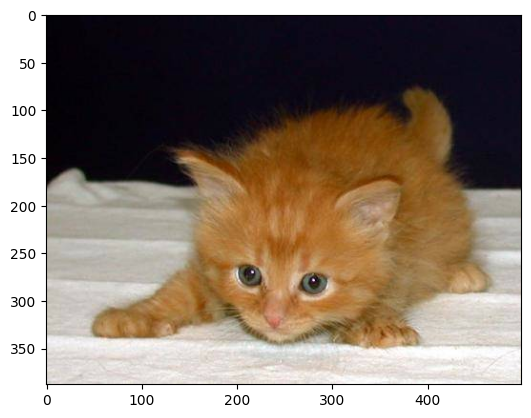

/content/cats_and_dogs_filtered/validation/dogs/dog.2138.jpg


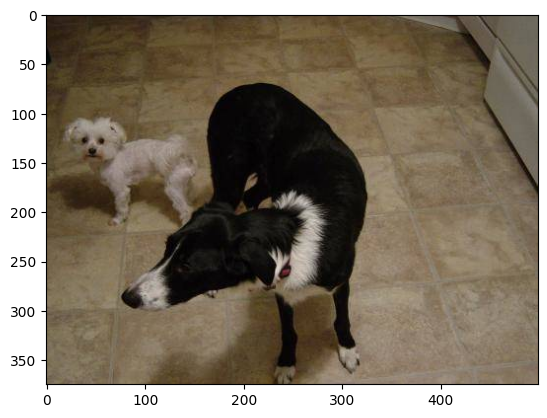

In [ ]:
# 이미지 보여주는 함수 실습
show_image(cv_image_read(list_of_test_images[10]))
show_image(cv_image_read(list_of_test_images[501]))

In [ ]:
# 테스트 메인 함수
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

def testmain(image_path):
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

    img_width, img_height = 224, 224
    transform_info = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                    ])
    #라벨 파일 읽기
    class_map = load_label_map('label_map.txt')
    num_classes = len(class_map)

    #지정된 모델 로딩
    model = MODEL(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt"

    model.load_state_dict(torch.load(model_str))
    model.eval()

    #image_path = list_of_test_images[501]
    opencv_image = cv_image_read(image_path)
    inference_result = inference_image(opencv_image, transform_info, model, DEVICE)
    inference_result = inference_result.cpu().detach().numpy()
    print_result(inference_result, class_map)
    show_image(opencv_image)

<ipython-input-18-7fefaf13e827>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_str))


/content/cats_and_dogs_filtered/validation/cats/cat.2084.jpg
[[9.999993e-01 7.106504e-07]]
cats


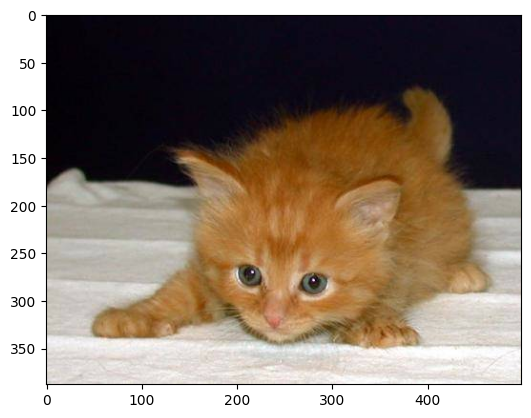

/content/cats_and_dogs_filtered/validation/dogs/dog.2138.jpg
[[3.7409754e-06 9.9999619e-01]]
dogs


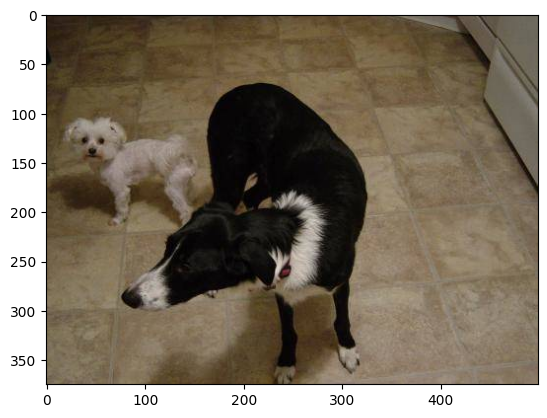

In [ ]:
# 테스트 이미지로 테스트 메인 함수 실행 1
image_path = list_of_test_images[10]
testmain(image_path)

# 테스트 이미지로 테스트 메인 함수 실행 2
image_path = list_of_test_images[501]
testmain(image_path)